## Prepare environment


In [3]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

import category_encoders as ce

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [4]:
# for local environment use this:
PATH = "../"

application_train = pd.read_csv(PATH + "data/raw/application_train.csv")
application_test = pd.read_csv(PATH + "data/raw/application_test.csv")

# Homework

### Common functions

In [5]:
def create_submission(
    X_test,
    model,
    submission_name : str
):
    y_pred = model.predict(X_test)
    sample_submission = pd.read_csv(PATH + 'data/raw/sample_submission.csv')
    sample_submission['TARGET'] = y_pred
    sample_submission.to_csv(PATH + 'data/submissions/' + submission_name, index = False)

## Models

### 1. Raw numeric features

In [6]:
numeric_features = [
    col for col in application_train.columns 
    if application_train[col].dtypes != object and col != 'TARGET'
    ]

In [7]:
X_train = application_train[numeric_features].fillna(0)
X_test = application_test[numeric_features].fillna(0)
y_train = application_train['TARGET']

In [8]:
lr = linear_model.LogisticRegression()
cross_val_score(estimator=lr, X=X_train, y=y_train, scoring='roc_auc', cv=3)

array([0.61835331, 0.61932282, 0.6209793 ])

In [9]:
clf = linear_model.LogisticRegression().fit(X_train, y_train)
create_submission(X_test, clf, "simple_model.csv")

In [10]:
# !kaggle competitions submit -c home-credit-default-risk -f /content/drive/MyDrive/Study/ML2021/hw2/data/submissions/simple_model.csv -m "Message"

**Result**: kaggle score is 0.5

### 2. Add class weigths, remove outliers

In [11]:
def remove_outliers(df: pd.DataFrame):
    for col in df:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        upper = q3 + 1.5 * iqr
        lower = q1 - 1.5 * iqr
        df[col].clip(lower, upper, inplace=True)
        # df[col].clip(q1, q3, inplace=True)

    return df

In [12]:
# I've handpicked this features with trial and error.
# Using other features for this model, roc-auc score falls down to 0.5.

features = [
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'DAYS_REGISTRATION',
    'DAYS_EMPLOYED',
    'DAYS_BIRTH',
    ]

In [13]:
X_train = remove_outliers(application_train[features])
y_train = application_train.TARGET
for col in X_train:
    X_train[col].fillna(X_train[col].median(), inplace=True)

In [14]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([282686,  24825]))

In train sample, there are about 10% of elements with target==true. I will use 'class_weight' to balance it out in classifier.

In [15]:
lr = linear_model.LogisticRegression(
    solver="liblinear", 
    random_state=19,
    class_weight={0: 0.1}
    )

cross_val_score(estimator=lr, X=X_train, y=y_train, scoring='roc_auc', cv=4)

array([0.71974494, 0.71583591, 0.71941971, 0.72196255])

Let's create submission.

In [16]:
X_test = remove_outliers(application_test[features])
for col in X_test:
    X_test[col].fillna(X_train[col].median(), inplace=True)

In [17]:
clf = lr.fit(X_train, y_train)
create_submission(X_test, clf, "balanced_classes.csv")

In [ ]:
# !kaggle competitions submit -c home-credit-default-risk -f /content/drive/MyDrive/Study/ML2021/hw2/data/submissions/balanced_classes.csv -m "Message"

100% 428k/428k [00:00<00:00, 2.01MB/s]
Successfully submitted to Home Credit Default Risk

**Result:** kaggle score is 0.63

### 3. Scale numeric features using MinMax scaler

In [18]:
def scale_and_fill_missing(df):
    cols = df.columns
    df = preprocessing.MinMaxScaler().fit_transform(df)

    imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
    imp_mean.fit(df)
    df = imp_mean.transform(df)

    df = pd.DataFrame(df, columns=cols)
    return df

In [19]:
features = [
    col for col in application_train.columns 
    if application_train[col].dtypes != object 
    and col != 'TARGET'
    ]

In [20]:
X_train = scale_and_fill_missing(application_train[features])
y_train = application_train.TARGET

In [21]:
lr = linear_model.LogisticRegression(
    # solver="saga", 
    # penalty="elasticnet",
    # l1_ratio=0.5,
    # C=0.0001,
    random_state=19,
    # class_weight={0: 0.1}
    class_weight='balanced'
    )

cross_val_score(estimator=lr, X=X_train, y=y_train, scoring='roc_auc', cv=4)

array([0.73307308, 0.73109233, 0.73236424, 0.73581923])

In [24]:
X_test = scale_and_fill_missing(application_test[features])
clf = lr.fit(X_train, y_train)
create_submission(X_test, clf, "scaled_features.csv")

In [25]:
# !kaggle competitions submit -c home-credit-default-risk -f {PATH}data/submissions/scaled_features.csv -m "with flag features"

**Result:** kaggle score is 0.66

### Add categorical data

In [26]:
def prepare_num_and_cat_data(df_num, df_cat, encoder):

    # target encoding
    df_cat = encoder.transform(df_cat) 

    # combine
    df = pd.concat([df_num, df_cat], axis=1)

    # fill missing numeric values with median
    df = SimpleImputer(missing_values=np.nan, strategy='median').fit_transform(df)

    # scale
    df = preprocessing.MinMaxScaler().fit_transform(df)

    return df

In [27]:
num_features = [
    col for col in application_train.columns
    if application_train[col].dtypes != object
    and col != 'TARGET'
]

cat_features = [
    col for col in application_train.columns
    if application_train[col].dtypes == object 
    ]

In [28]:
# prepare target encoder to use on test data
X_train_cat = application_train[cat_features]
y_train = application_train.TARGET
encoder = ce.TargetEncoder().fit(X_train_cat, y_train)

X_train = prepare_num_and_cat_data(
    df_num = application_train[num_features],
    df_cat = X_train_cat,
    encoder = encoder
)

In [29]:
lr = linear_model.LogisticRegression(
    random_state=19,
    class_weight='balanced'
    )

cross_val_score(estimator=lr, X=X_train, y=y_train, scoring='roc_auc', cv=2)

array([0.74383911, 0.7447345 ])

This again gives us slight improvement (locally). Let's make a submission.

In [30]:
X_test = prepare_num_and_cat_data(
    df_num = application_test[num_features],
    df_cat = application_test[cat_features],
    encoder = encoder
)

In [31]:
clf = lr.fit(X_train, y_train)
create_submission(X_test, clf, 'categorical_features.csv')

In [32]:
# !kaggle competitions submit -c home-credit-default-risk -f {PATH}data/submissions/categorical_features.csv -m "with a function"

**Result:** kaggle score is 0.65. It is a small downgrade.

*Note:* without class_weight='balanced' in Logistic Regression score falls down to 0.5.

### WOE and IV

- What are Weigh of Evidence and Information Value: https://towardsdatascience.com/churn-analysis-information-value-and-weight-of-evidence-6a35db8b9ec5
- Formula: https://stats.stackexchange.com/questions/93170/why-do-we-calculate-information-value

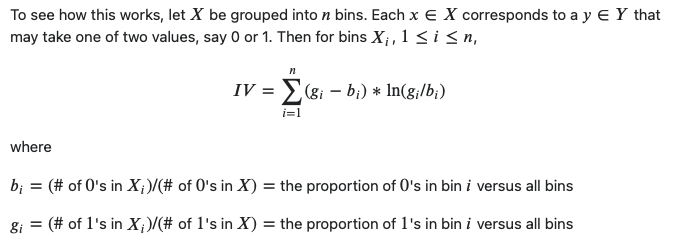

In [33]:
sample_size = application_train['TARGET'].size
bins_num = 15

y_good = application_train['TARGET'].sum()
y_bad = sample_size - y_good

information_values = []

In [34]:
cat_features = []
num_features = []
for col, val_count in application_train.nunique().items():
    if col == 'TARGET':
        continue

    # assume all features with less than 30 values are categorical
    if val_count <= bins_num or application_train[col].dtypes == object:
        cat_features.append(col)
    else:
        num_features.append(col)

In [35]:
for ft in cat_features:
    df = application_train[[ft, 'TARGET']]
    g = df.groupby(ft).sum() / y_good
    b = (df.groupby(ft).count() - df.groupby(ft).sum()) / y_bad
    WOE = np.log(g / b)
    IV = np.sum((g - b) * WOE)[0]
    if IV > 0.05 and IV != np.inf:
        print(ft, IV)
    if IV != np.inf:
        information_values.append([IV, ft])

NAME_EDUCATION_TYPE 0.05083554290147044
OCCUPATION_TYPE 0.06761072955432301
REGION_RATING_CLIENT_W_CITY 0.05120149755009072
ORGANIZATION_TYPE 0.07336774725876796


In [36]:
for ft in num_features:
    df = application_train[[ft, 'TARGET']]
    df.sort_values(by=ft, inplace=True)

    # split data into bins, separate and mark by quantile values
    df['bin'] = pd.qcut(df[ft], bins_num, duplicates='drop').apply(lambda x: x.left).astype(float)

    g = df.groupby('bin')['TARGET'].sum() / y_good
    b = (df.groupby('bin')['TARGET'].count() - df.groupby('bin')['TARGET'].sum()) / y_bad
    WOE = np.log(g / b)
    IV = np.sum((g - b) * WOE)
    if IV > 0.05 and IV != np.inf:
        print(ft, IV)
    
    if IV != np.inf:
        information_values.append([IV, ft])

AMT_CREDIT 0.05212494858651682
AMT_GOODS_PRICE 0.09663201504784073
DAYS_BIRTH 0.08513976411636788
DAYS_EMPLOYED 0.10247722502747905
EXT_SOURCE_1 0.1524182770357392
EXT_SOURCE_2 0.3152921824992717
EXT_SOURCE_3 0.32996580828092587


In [37]:
information_values.sort(reverse=True)
best_iv = information_values[:12]
plt.figure(figsize=(15, 10))
sns.barplot(y=[bf[1] for bf in best_iv], x=[bf[0] for bf in best_iv], orient='h')
plt.title("Information values")
plt.show()

In [38]:
best_features = [bf[1] for bf in best_iv]
print(best_features)

['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_EMPLOYED', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'ORGANIZATION_TYPE', 'OCCUPATION_TYPE', 'AMT_CREDIT', 'REGION_RATING_CLIENT_W_CITY', 'NAME_EDUCATION_TYPE', 'REGION_RATING_CLIENT']


### Putting all together

Now we know the most valuable features, let's train Logistic Regression with them.

In [39]:
# for explanations see 'Add categorical data' block

def prepare_num_and_cat_data(df_num, df_cat, encoder):
    df_cat = encoder.transform(df_cat) 
    df = pd.concat([df_num, df_cat], axis=1)
    df = SimpleImputer(missing_values=np.nan, strategy='median').fit_transform(df)
    df = preprocessing.MinMaxScaler().fit_transform(df)
    return df

In [40]:
cat_features = [
    'ORGANIZATION_TYPE',
    'OCCUPATION_TYPE',
    'NAME_EDUCATION_TYPE'
]

num_features = [
    'EXT_SOURCE_3', 
    'EXT_SOURCE_2', 
    'EXT_SOURCE_1', 
    'DAYS_EMPLOYED', 
    'AMT_GOODS_PRICE', 
    'DAYS_BIRTH', 
    'AMT_CREDIT', 
    'REGION_RATING_CLIENT_W_CITY', 
    'REGION_RATING_CLIENT'    
]

In [41]:
X_train_cat = application_train[cat_features]
y_train = application_train.TARGET
# encoder = ce.TargetEncoder().fit(X_train_cat, y_train)
encoder = ce.WOEEncoder(cols=cat_features).fit(X_train_cat, y_train)

X_train = prepare_num_and_cat_data(
    df_num = remove_outliers(application_train[num_features]),
    df_cat = X_train_cat,
    encoder = encoder
)

X_train = pd.DataFrame(X_train, columns=num_features + cat_features)

In [42]:
lr = linear_model.LogisticRegression(
    solver='saga',
    penalty='elasticnet',
    l1_ratio=0.5,
    random_state=19,
    class_weight='balanced'
    )

cross_val_score(estimator=lr, X=X_train, y=y_train, scoring='roc_auc', cv=3)

array([0.73378348, 0.73218862, 0.73914108])

In [43]:
X_test = prepare_num_and_cat_data(
    df_num = application_test[num_features],
    df_cat = application_test[cat_features],
    encoder = encoder
)

In [44]:
clf = lr.fit(X_train, y_train)
create_submission(X_test, clf, 'woe_iv.csv')

In [250]:
# !kaggle competitions submit -c home-credit-default-risk -f {PATH}data/submissions/categorical_features.csv -m "last try"

100% 428k/428k [00:00<00:00, 2.04MB/s]
Successfully submitted to Home Credit Default Risk

**Result:** kaggle score is 0.66 again. Too bad.

## Итоги

### Что я сделал:
- построил несколько простых моделей логистической регрессии
- поигрался с параметрами (solver, class_weight)
- убрал выбросы из данных
- масштабировал данные с помощью MinMax scaler
- добавил категориальные признаки
- Использовал Weight of evidence и Information value для определения важности признаков, как категориальных, так и численных (continuous) с разбиением на корзины (bins)

### Выводы:
- MinMax scaler дает лучший результат. Практически неважно, какие фичи ему скармливать, он вернет примерно одинаковый скор == 0.66
- Пока что не очень понятно, насколько хорошо работает Information Value, надо будет изучить дальше на практике. 
- При выборе фичей стоит смотреть на их распределение (графики)
- В следующий раз хочу обучить несколько моделей и сделать из них лес
